In [218]:
'''MPC WITH A SIMPLIFIED STATE SPACE MODEL FOR DEBUGGING / LEARNING PURPOSES'''
'''Made by: Justin E.'''
# import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sympy as sp
from sympy.utilities.lambdify import lambdify
from matplotlib import rcParams
import casadi as ca
import do_mpc

In [219]:
# Helpers

# Inertia Tensors (numeric, gimbals unused)
I = np.matrix([[0.5, 0.0, 0.0],
               [0.0, 0.5, 0.0],
               [0.0, 0.0, 0.5]])
I_s = np.matrix([[1.0, 0.0, 0.0],
               [0.0, 1.0, 0.0],
               [0.0, 0.0, 1.0]])
I_a = np.matrix([[0.5, 0.0, 0.0],
               [0.0, 0.5, 0.0],
               [0.0, 0.0, 0.5]])
I_b = np.matrix([[0.5, 0.0, 0.0],
               [0.0, 0.5, 0.0],
               [0.0, 0.0, 0.5]])

# COP / COT / COM Offsets (numeric)
# TODO: add gimbal offset, make rc and rt time dependent (since COM is moving on the rocket due to fuel consumption)
rc = np.array([0.0, 0.0, 0.1])  # cop offset
rt = np.array([0.0, 0.0, -0.1])  # cot offset
r_rcs = np.array([0.0,0.0,0.05])  # rcs offset

# AoA should be in radians
# TODO: FIND FHL CD REGRESSION. This is currently using monoprop data.
# NOTE: As of 5/16/2025, this is no longer used. AoA and C_d's are now all auxiliary variables as per do-mpc's definition.
# Kept for reference.

def get_cd_x(AoA):
    # Gets body frame c_d_x from AoA. Note that Cd_x = Cd_y for our body coordinate frame.
    return -0.449*ca.fabs((ca.cos(3.028*AoA*180/np.pi))) + 0.463

def get_cd_z(AoA):
    # Gets body frame c_d_z from AoA.
    return -0.376*ca.fabs((ca.cos(5.675*AoA*180/np.pi))) + 1.854


In [220]:
# Build state space model
# fully 6dof with time varying mass. 
# Gimbal movements and associated gyroscopic forces ignored

# define numeric variables (adjust as needed).
# CD coefficients are defined as a function of AoA. AoA is a time varying parameter. Defined later.
g = 9.81  # gravity
m_0 = 1.0  # starting mass. 
m_min = 0.1 # minimum mass.
rho = 1.225  # air density
A = 0.1  # cross-sectional area
C_d = 0.5  # drag coefficient
alpha = 0.001 # mass flow rate coefficient (determine empirically, given by propulsion team)


# define equations of motion
# x_d = f(x,u), where f is some nonlinear function. 
model = do_mpc.model.Model('continuous')

# Linear states
r = model.set_variable('_x', 'r', shape=(3,1))
r_dot = model.set_variable('_x', 'r_dot', shape=(3,1))
# Angular states
omega = model.set_variable('_x', 'omega', shape=(3,1))
omega_dot = model.set_variable('_x', 'omega_dot', shape=(3,1))
# Mass state
m = model.set_variable('_x', 'm', shape=(1,1))
# Control inputs
T = model.set_variable('_u', 'T')
a = model.set_variable('_u', 'a')
b = model.set_variable('_u', 'b')
R1 = model.set_variable('_u', 'R1') # clockwise - positive, only one direction
R2 = model.set_variable('_u', 'R2') # counterclockwise - negative, only one direction

# Mass flow rate
rhs_m = -alpha*T

# Rotational Motion
# first, create rotation matrices from euler angles
cphi, sphi   = ca.cos(omega[2]),   ca.sin(omega[2]) # roll
cth,  sth    = ca.cos(omega[1]), ca.sin(omega[1]) # pitch
cpsi, spsi   = ca.cos(omega[0]),   ca.sin(omega[0]) # yaw

R_z = ca.blockcat([[ cphi, -sphi, 0],
                   [ sphi,  cphi, 0],
                   [    0,     0, 1]])

R_y = ca.blockcat([[ cth, 0, sth],
                   [   0, 1,   0],
                   [-sth, 0, cth]])

R_x = ca.blockcat([[1, 0,    0],
                   [0, cpsi, -spsi],
                   [0, spsi,  cpsi]])

R_bf = ca.mtimes(R_z, R_y)
R_bf = ca.mtimes(R_bf, R_x)
R_wf = R_bf.T

zero_err = np.full(3, 1e-6) # small number to avoid division by zero

model.set_expression('AoA', ca.acos(ca.dot(r_dot+zero_err, np.array([0, 0, 1]))/ca.norm_2(r_dot+zero_err))) # angle of attack in radians
AoA = model.aux['AoA']
model.set_expression('C_dx', -0.449*(ca.cos(3.028*AoA*180/np.pi)) + 0.463)
model.set_expression('C_dy', -0.449*(ca.cos(3.028*AoA*180/np.pi)) + 0.463)
model.set_expression('C_dz', -0.376*(ca.cos(5.675*AoA*180/np.pi)) + 1.854)
C_dx = model.aux['C_dx']
C_dy = model.aux['C_dy']
C_dz = model.aux['C_dz']

# first, calculate torques in body.
#v velocities in body frame, needed for drag calculation.
r_dot_bf = ca.mtimes(R_bf, r_dot)

# TODO: update relevant A and C_d values for each axis.
F_d_bf = ca.vertcat(
    -0.5*rho*A*C_d*(ca.fabs(r_dot_bf[0]))*r_dot_bf[0],
    -0.5*rho*A*C_d*(ca.fabs(r_dot_bf[1]))*r_dot_bf[1],
    -0.5*rho*A*C_d*(ca.fabs(r_dot_bf[2]))*r_dot_bf[2]
)

F_t_bf = ca.vertcat(
    T*ca.cos(b)*ca.sin(a),
    T*ca.sin(b),
    T*ca.cos(b)*ca.cos(a)
)

F_g_wf = ca.vertcat(
    0,
    0,
    -m*g
)
F_g_bf = ca.mtimes(R_bf, F_g_wf) 

# Net force and linear in body frame
F_net_bf = F_t_bf + F_d_bf + F_g_bf

# Acceleration in world frame
F_net_wf = ca.mtimes(R_wf, F_net_bf)
rhs_r_dot = ca.mtimes(1/m, F_net_wf)

# Net torque in body frame
tau_d_bf = ca.cross(rc, F_d_bf)
tau_t_bf = ca.cross(rt, F_t_bf)
tau_rcs_bf = r_rcs*(R1 - R2)
tau_net_bf = tau_d_bf + tau_t_bf + tau_rcs_bf - ca.cross(omega_dot, ca.mtimes(I, omega_dot))
# Net torque in world frame
# tau_net_wf = ca.mtimes(R_wf, tau_net_bf)
# I_wf = ca.mtimes(R_wf, I)
# I_wf = ca.mtimes(I_wf, R_wf.T)
# I_wf_inv = ca.inv(I_wf)
I_inv = ca.inv(I)
ang_accel_bf = ca.mtimes(I_inv, tau_net_bf)

# angular acceleration in world frame
rhs_omega_dot = ca.mtimes(R_wf, ang_accel_bf)

#Translational Velocity
rhs_r = ca.vertcat(
    r_dot[0],                                                            # ẋ = v_x
    r_dot[1],                                                            # ẏ = v_y
    r_dot[2],                                                            # ż = v_z
)

# Rotational Velocity
rhs_omega = ca.vertcat(
    omega_dot[0],                                                            # φ̇ = ω_x
    omega_dot[1],                                                            # θ̇ = ω_y
    omega_dot[2],                                                            # ψ̇ = ω_z
)


model.set_rhs('r', rhs_r)
model.set_rhs('r_dot', rhs_r_dot)
model.set_rhs('omega', rhs_omega)
model.set_rhs('omega_dot', rhs_omega_dot)
model.set_rhs('m', rhs_m)

# defining reference variables
r_ref = model.set_variable('_tvp', 'r_ref', shape=(3,1))
r_dot_ref = model.set_variable('_tvp', 'r_dot_ref', shape=(3,1))
omega_ref = model.set_variable('_tvp', 'omega_ref', shape=(3,1))
omega_dot_ref = model.set_variable('_tvp', 'omega_dot_ref', shape=(3,1))
m_ref = model.set_variable('_tvp', 'm_ref', shape=(1,1))

model.setup()

In [221]:
# Configuring controller
mpc = do_mpc.controller.MPC(model)
setup_mpc = {
    # automatically discretized with collocation
    'n_horizon': 5,
    't_step': 0.1,
    'n_robust': 0, # default to 0 if not specified. I don't know what this does.
    'store_full_solution': True,
}
mpc.set_param(**setup_mpc)

In [222]:
# Cost Function. Will be defined as a quadratic function
# error between desired and actual state as well as control effort.
x_ref = r_ref[0]  # desired x position
x_dot_ref = r_dot_ref[0]  # desired x velocity
y_ref = r_ref[1]  # desired y position
y_dot_ref = r_dot_ref[1]  # desired y velocity
z_ref = r_ref[2]  # desired altitude
z_dot_ref = r_dot_ref[2]  # desired vertical velocity
m_ref = m_0  # desired mass (use least amount of fuel possible)

phi_ref = omega_ref[0]  # desired pitch angle
theta_ref = omega_ref[1]  # desired yaw angle
psi_ref = omega_ref[2]  # desired roll angle
phi_dot_ref = omega_dot_ref[0]  # desired pitch rate
theta_dot_ref = omega_dot_ref[1]  # desired yaw rate
psi_dot_ref = omega_dot_ref[2]  # desired roll rate

dx = r[0] - x_ref
dx_dot = r_dot[0] - x_dot_ref
dy = r[1] - y_ref
dy_dot = r_dot[1] - y_dot_ref
dz = r[2] - z_ref
dz_dot = r_dot[2] - z_dot_ref

dphi = omega[0] - phi_ref
dphi_dot = omega_dot[0] - phi_dot_ref
dtheta = omega[1] - theta_ref
dtheta_dot = omega_dot[1] - theta_dot_ref
dpsi = omega[2] - psi_ref
dpsi_dot = omega_dot[2] - psi_dot_ref

dm = m - m_ref

err_vec = ca.vertcat(
    dx,
    dx_dot,
    dy,
    dy_dot,
    dz,
    dz_dot,
    dphi,
    dphi_dot,
    dtheta,
    dtheta_dot,
    dpsi,
    dpsi_dot,
    dm
)
# Cost matrix
Q = np.diag([3.0, 3.0, 3.0, # xyz position state penalty
             3.0, 3.0, 3.0, # xyz velocity state penalty
             9.0, 9.0, 2.0, # pitch, yaw, roll angle penalty
             9.0, 9.0, 2.0, # pitch, yaw, roll rate penalty
             0.01 # mass penalty. Low because if its too high its not gonna work.
             ])

# m_term is mayer term and l_term is lagrange term. 
# TODO: figure out what these are.
m_term = ca.mtimes(err_vec.T, Q)  # quadratic term
m_term = ca.mtimes(m_term, err_vec)  # quadratic term
l_term = m_term

mpc.set_objective(mterm=m_term, lterm=l_term)
mpc.set_rterm(T=0.1, a=0.2, b=0.2, R1 = 0.1, R2 = 0.1)  # control effort penalty

tvp_template = mpc.get_tvp_template()

# define general desired state(s)
# to be followed at (mostly) all times
r_dot_ref_num = np.array([0.0, 0.0, 0.0])
omega_ref_num = np.array([0.0, 0.0, 0.0])
omega_dot_ref_num = np.array([0.0, 0.0, 0.0])

# define ascent phase desired state(s)
r_ref_num_hi_hover = np.array([2.0, 2.0, 2.0])
x_ref_num_ascent = np.concatenate((r_ref_num_hi_hover, np.array([0.0,0.0,0.2]), omega_ref_num, omega_dot_ref_num, m_ref/2), axis=None)
# reference velocity is 1 m/s in the z direction for ascent phase.

# define hi hover phase desired state(s)
x_ref_num_hi_hover = np.concatenate((r_ref_num_hi_hover, r_dot_ref_num, omega_ref_num, omega_dot_ref_num, m_min), axis=None)

# define descent phase desired state(s)
# TAKE PRECAUTION, DO NOT SET Z VELOCITY TO BE TOO LOW, IT WILL CRASH INTO THE GROUND.
r_ref_num_lo_hover = np.array([0.0, 0.0, 0.2])
x_ref_num_descent = np.concatenate((r_ref_num_lo_hover, np.array([0.0,0.0,-0.2]), omega_ref_num, omega_dot_ref_num, m_min), axis=None)

# define lo hover phase desired state(s)
x_ref_num_lo_hover = np.concatenate((np.array([0.0,0.0,0.0]), r_dot_ref_num, omega_ref_num, omega_dot_ref_num, m_min), axis=None)

def tvp_fun(t_now):
    # define the reference trajectory here
    # Ascend for 10 seconds, hover for 5, descend in 7.5, then hover for the remainder.
    # Simulation time should be longer than this for best results.
    if t_now < 10:
        x_ref_num = x_ref_num_ascent
    elif t_now < 15:
        x_ref_num = x_ref_num_hi_hover
    elif t_now < 22.5:
        x_ref_num = x_ref_num_descent
    else:
        x_ref_num = x_ref_num_lo_hover
    tvp_template['_tvp', :] = x_ref_num
    # tvp_template['_tvp', :] = x_ref_num_hi_hover
    return tvp_template

mpc.set_tvp_fun(tvp_fun)

mpc.bounds['lower', '_x', 'r'] = np.array([-np.inf, -np.inf, 0])
mpc.bounds['upper', '_x','r'] = np.inf
mpc.bounds['lower', '_x', 'r_dot'] = -np.inf
mpc.bounds['upper', '_x', 'r_dot'] = np.inf
mpc.bounds['lower', '_x', 'omega'] = -np.inf
mpc.bounds['upper', '_x', 'omega'] = np.inf
mpc.bounds['lower', '_x', 'omega_dot'] = -np.inf
mpc.bounds['upper', '_x', 'omega_dot'] = np.inf
mpc.bounds['lower', '_x', 'm'] = m_min  # mass cannot be less than minimum mass (dry mass)
mpc.bounds['upper', '_x', 'm'] = m_0  # mass cannot be higher than initial mass (wet mass)
mpc.bounds['lower', '_u', 'a'] = -np.pi/12  # gimbal angle cannot be too low
mpc.bounds['upper', '_u', 'a'] = np.pi/12  # gimbal angle cannot be too high
mpc.bounds['lower', '_u', 'b'] = -np.pi/12  # gimbal angle cannot be too low
mpc.bounds['upper', '_u', 'b'] = np.pi/12  # gimbal angle cannot be too high
mpc.bounds['upper', '_u', 'T'] = 15.0  # thrust cannot be too high
mpc.bounds['lower', '_u', 'T'] = 0.0  # thrust cannot be lower than burnout thrust
mpc.bounds['lower', '_u', 'R1'] = 0  # rcs cannot be negative
mpc.bounds['upper', '_u', 'R1'] = 1  # max rcs1 thrust
mpc.bounds['lower', '_u', 'R2'] = 0  # rcs cannot be negative
mpc.bounds['upper', '_u', 'R2'] = 1  # max rcs2 thrust

# Scaling can be done, will not be done here because I don't know how it works or if its needed.
mpc.setup()


In [223]:
# Configure built-in simulator.
simulator = do_mpc.simulator.Simulator(model)

simulator.set_param(t_step = 0.1)

sim_tvp_template = simulator.get_tvp_template()

def tvp_fun_sim(t_now):
    # all setpoints are internal to the MPC
    return sim_tvp_template

simulator.set_tvp_fun(tvp_fun_sim)

simulator.setup()

In [224]:
# Initialize and start control loop
x0 = np.array([[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [m_0]])  # initial state
mpc.x0 = x0
mpc.set_initial_guess()
simulator.x0 = x0

In [225]:

# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['figure.figsize'] = (14, 12)   # width, height in inches
mpl.rcParams['axes.grid'] = True
mpl.rcParams['legend.loc'] = 'best'

mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

In [226]:
%%capture
# We just want to create the plot and not show it right now. This "inline magic" supresses the output.
fig, ax = plt.subplots(6, sharex=True, figsize=(16,9))
fig.align_ylabels()

In [227]:
%%capture
for g in [sim_graphics, mpc_graphics]:
    # Plot the state variables on the first axis:
    g.add_line(var_type='_x', var_name='r', axis=ax[0])
    g.add_line(var_type='_x', var_name='r_dot', axis=ax[1])
    g.add_line(var_type='_x', var_name='omega', axis=ax[2])
    g.add_line(var_type='_x', var_name='omega_dot', axis=ax[3])

    # Plot the control outputs on the second axis:
    g.add_line(var_type='_u', var_name='T', axis=ax[4])
    g.add_line(var_type='_u', var_name='a', axis=ax[4])
    g.add_line(var_type='_u', var_name='b', axis=ax[4])
    g.add_line(var_type='_u', var_name='R1', axis=ax[4])
    g.add_line(var_type='_u', var_name='R2', axis=ax[4])

    # Plot the mass on the last axis:
    g.add_line(var_type='_x', var_name='m', axis=ax[5])

ax[0].set_ylabel('position[m]')
ax[1].set_ylabel('velocity[m/s]')
ax[2].set_ylabel('e-ang[rad]')
ax[3].set_ylabel('ang-vel[rad/s]')
ax[4].set_ylabel('control [N/rad]')
ax[5].set_ylabel('mass [kg]')

ax[0].set_xlabel('time [s]')
ax[1].set_xlabel('time [s]')
ax[2].set_xlabel('time [s]')
ax[3].set_xlabel('time [s]')
ax[4].set_xlabel('time [s]')
ax[5].set_xlabel('time [s]')

In [228]:
# run simulator without any control. This is to see if what we've done so far is correct,
# both in terms of code logic and the state space model itself.

simulator.reset_history()

u0 = np.zeros((5,1))
u0[2] = 0.01 # gimbal a, on its own affecting y position.
u0[0] = 10
for i in range(300):
    simulator.make_step(u0)
    # print(.x['r'])

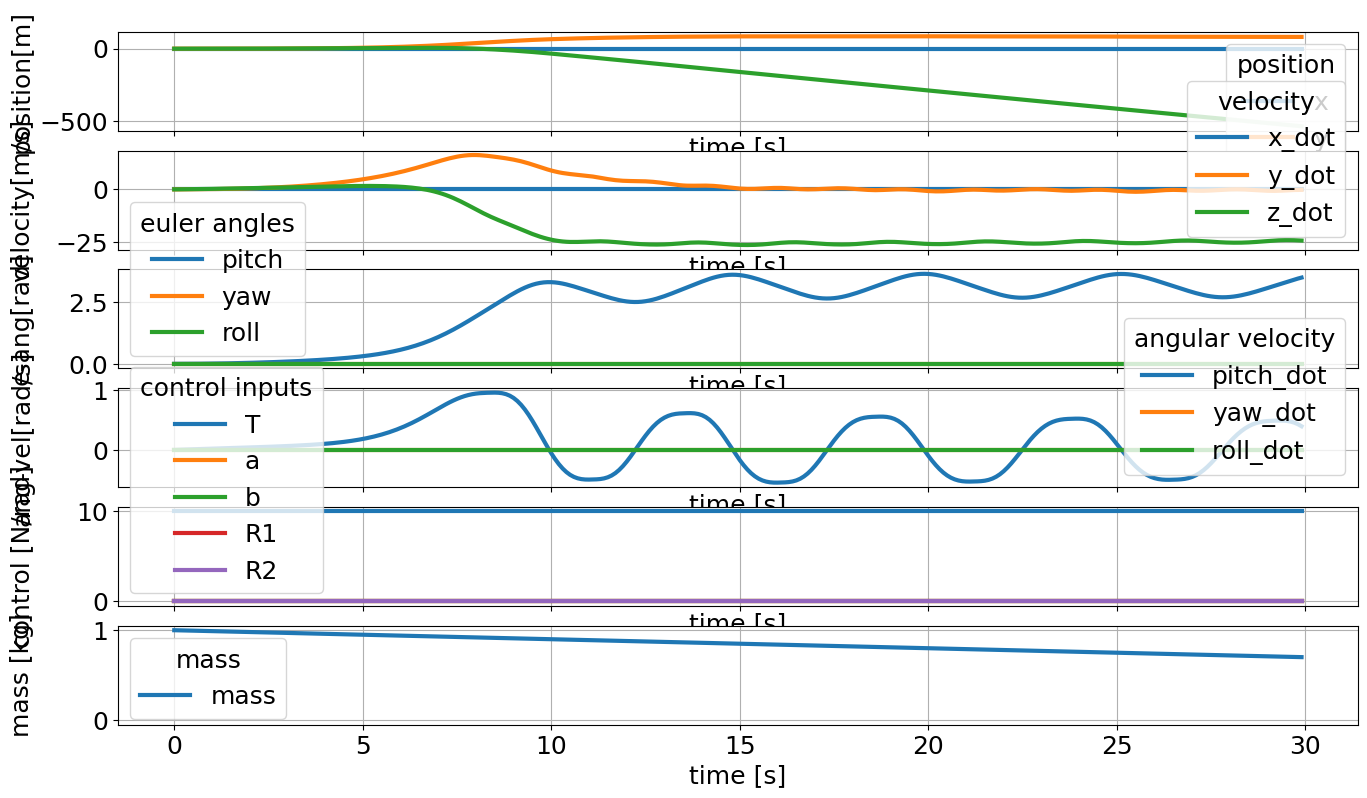

In [229]:
# Plot results until current time
sim_graphics.plot_results()
# Reset the limits on all axes in graphic to show the data.
sim_graphics.reset_axes()

# add info to the plot
pos_labels = ['x_pos', 'y_pos', 'z_pos']
vel_labels = ['x_dot', 'y_dot', 'z_dot']
omega_labels = ['pitch', 'yaw', 'roll']
omega_dot_labels = ['pitch_dot', 'yaw_dot', 'roll_dot']

pos_lines = sim_graphics.result_lines['_x','r']
vel_lines = sim_graphics.result_lines['_x','r_dot']
omega_lines = sim_graphics.result_lines['_x','omega']
omega_dot_lines = sim_graphics.result_lines['_x','omega_dot']
control_lines = sim_graphics.result_lines['_u', 'T']+sim_graphics.result_lines['_u', 'a']+sim_graphics.result_lines['_u', 'b']+sim_graphics.result_lines['_u', 'R1']+sim_graphics.result_lines['_u', 'R2']
mass_line = sim_graphics.result_lines['_x', 'm']

ax[0].legend(pos_lines, 'xyz', title='position')

ax[1].legend(vel_lines, vel_labels,title='velocity')

ax[2].legend(omega_lines, omega_labels, title='euler angles')

ax[3].legend(omega_dot_lines, omega_dot_labels, title='angular velocity')

ax[4].legend(control_lines, ['T', 'a', 'b', 'R1', 'R2'], title='control inputs')

ax[5].legend(mass_line, ['mass'], title='mass')
# Show the figure:
fig

In [48]:
# Once verified, we can run the actual control loop.

simulator.reset_history()
simulator.x0 = x0
mpc.reset_history()


In [49]:
%%capture
for i in range(400):
    # print('step', i)
    u0 = mpc.make_step(x0)
    x0 = simulator.make_step(u0)

SystemError: <built-in function Function_call> returned a result with an exception set

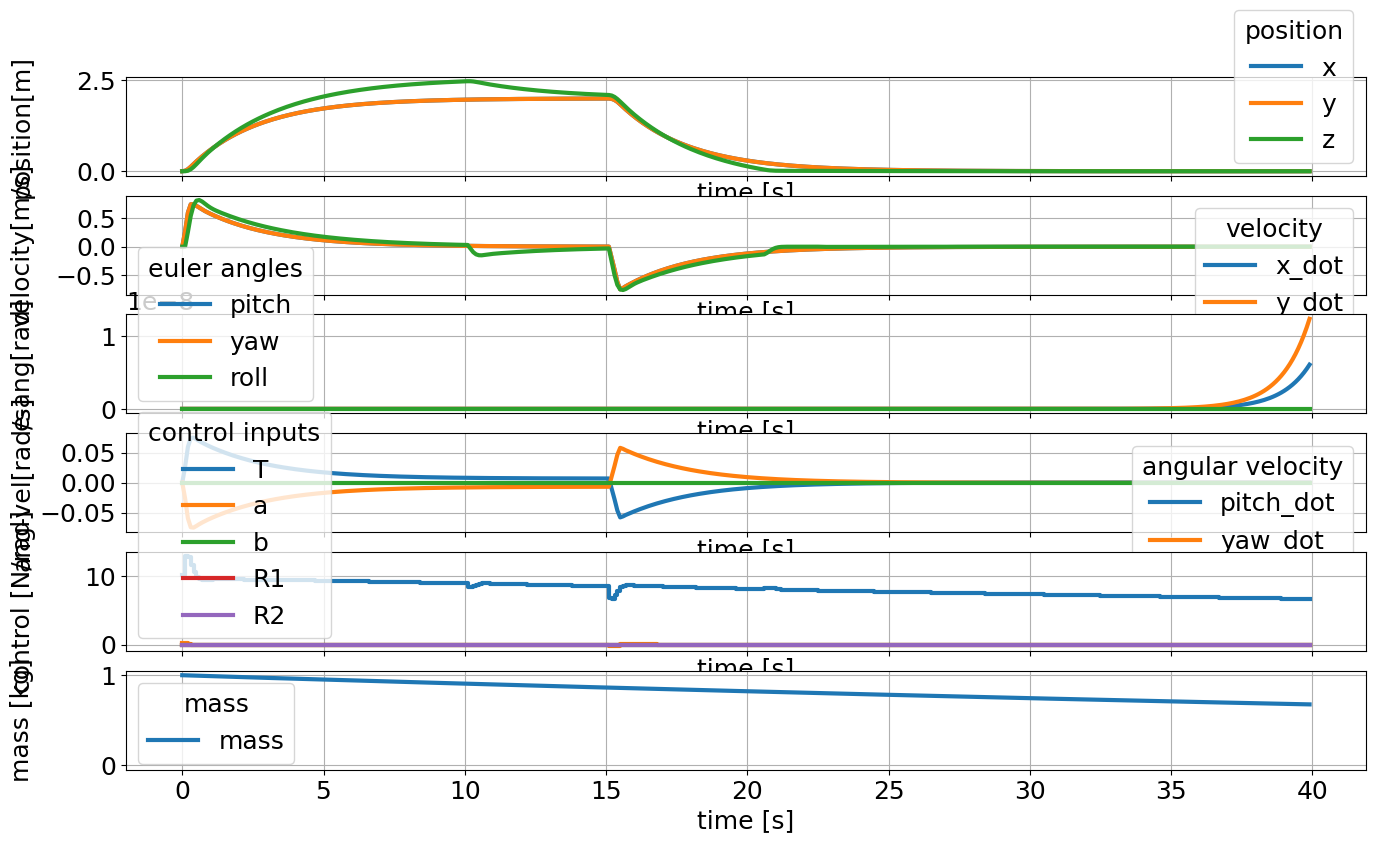

In [ ]:
# Plot results until current time
sim_graphics.plot_results()
# Reset the limits on all axes in graphic to show the data.
sim_graphics.reset_axes()

# add info to the plot
pos_labels = ['x_pos', 'y_pos', 'z_pos']
vel_labels = ['x_dot', 'y_dot', 'z_dot']
omega_labels = ['pitch', 'yaw', 'roll']
omega_dot_labels = ['pitch_dot', 'yaw_dot', 'roll_dot']

pos_lines = sim_graphics.result_lines['_x','r']
vel_lines = sim_graphics.result_lines['_x','r_dot']
omega_lines = sim_graphics.result_lines['_x','omega']
omega_dot_lines = sim_graphics.result_lines['_x','omega_dot']
control_lines = sim_graphics.result_lines['_u', 'T']+sim_graphics.result_lines['_u', 'a']+sim_graphics.result_lines['_u', 'b']+sim_graphics.result_lines['_u', 'R1']+sim_graphics.result_lines['_u', 'R2']
mass_line = sim_graphics.result_lines['_x', 'm']

ax[0].legend(pos_lines, 'xyz', title='position')

ax[1].legend(vel_lines, vel_labels,title='velocity')

ax[2].legend(omega_lines, omega_labels, title='euler angles')

ax[3].legend(omega_dot_lines, omega_dot_labels, title='angular velocity')

ax[4].legend(control_lines, ['T', 'a', 'b', 'R1', 'R2'], title='control inputs')

ax[5].legend(mass_line, ['mass'], title='mass')
# Show the figure:
fig